In [0]:
#!pip3 install https://download.pytorch.org/whl/cu100/torch-1.0.1.post2-cp36-cp36m-linux_x86_64.whl
#!pip3 install torchvision

In [0]:
import time

import torch
import torch.optim as optim

import torch.nn as nn
import torch.nn.functional as F

from sklearn.metrics import accuracy_score

import numpy as np
import PIL
import random
from IPython.core.display import Image, display

import matplotlib.pyplot as plt

In [0]:
#отключает warnings pytorch
import warnings
warnings.filterwarnings('ignore')

In [0]:
print(torch.__version__)
print(torch.cuda.is_available())

print(torch.cuda.device_count(), torch.cuda.get_device_name(0))

print(torch.cuda.current_device())
print(torch.cuda.device(0))
print("CudaVersion : ",torch.version.cuda)

1.0.1.post2
True
1 Tesla K80
0
CudaVersion :  10.0.130


In [0]:
DEVICE_ID = 0
DEVICE = torch.device('cuda:%d' % DEVICE_ID)
torch.cuda.set_device(DEVICE_ID)

### Для запуска без GPU раскомментировать и закоментировать код выше
# DEVICE = torch.device('cpu')

In [0]:
np.random.seed(100500)

def data2image(data):
    res = np.transpose(np.reshape(data ,(3, 32,32)), (1,2,0))
    return PIL.Image.fromarray(np.uint8(res))

def imshow(img):
    if isinstance(img, torch.Tensor): img = img.numpy().astype('uint8')
    plt.imshow(np.transpose(img, (1, 2, 0)))
    
def prediction2classes(output_var):
    _, predicted = torch.max(output_var.data, 1)
    predicted.squeeze_()
    classes = predicted.tolist()
    return classes

def make_solution_pytorch(net, input_tensor, a_batch_size):
    res = []
    net = net.eval()
    cur_pos = 0
    while cur_pos <= len(input_tensor):
        outputs = net(input_tensor[cur_pos:cur_pos+a_batch_size])
        res += prediction2classes(outputs)
        cur_pos += a_batch_size
    return res

In [0]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from PIL import Image

class CifarDataset(Dataset):
    def __init__(self, input_path, is_train=True, transform=None):
                        
        data = np.load(input_path)
        if is_train: 
            self.Y, self.X = np.hsplit(data, [1]) 
            self.Y = [item[0] for item in self.Y]
        else: 
            self.X = data
            self.Y = None
            
        self.X = self.X.reshape((self.X.shape[0], 3, 32, 32))
        self.X = self.X.transpose((0, 2, 3, 1)) #приводим к виду (N, H, W, C)
        self.X = [Image.fromarray(img) for img in self.X]
                
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        
        sample = self.X[idx]

        if self.transform: sample = self.transform(sample)

        if self.Y is None: return sample
        else: return (sample, self.Y[idx])

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
#тут папки с проблема должны быть заключены в ""
PATH_OF_DATA= '/content/gdrive/"My Drive"/"Colab Notebooks"/homework_4_ResNet'
!ls {PATH_OF_DATA}

homework_4_no_classes.test.npy	my_solution.csv
homework_4.train.npy		my_solution_lenet.csv


In [0]:
#Тут папки с пробелами НЕ надо заключать в ""
DATA_PATH  = ''
train_path = 'homework_4.train.npy'
test_path  = 'homework_4_no_classes.test.npy'

In [0]:
np_mean = np.mean([item[0].numpy() for item in CifarDataset(DATA_PATH + train_path, transform=transforms.ToTensor())], axis=(0,2,3))
np_std = np.std([item[0].numpy() for item in CifarDataset(DATA_PATH + train_path, transform=transforms.ToTensor())], axis=(0,2,3))

In [0]:
np_mean, np_mean.shape

(array([0.50760865, 0.48708203, 0.44149536], dtype=float32), (3,))

In [0]:
np_std, np_std.shape

(array([0.26764476, 0.2567687 , 0.27647924], dtype=float32), (3,))

In [0]:
cifar_transform_norm = transforms.Compose([
    transforms.Pad(4),
    transforms.RandomCrop(32),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(torch.FloatTensor(np_mean), torch.FloatTensor(np_std))
]
)

cifar_test_transform_norm = transforms.Compose([    
    transforms.ToTensor(),
    transforms.Normalize(torch.FloatTensor(np_mean), torch.FloatTensor(np_std))
]
)

In [0]:
dataset_train_norm = CifarDataset(DATA_PATH + train_path, transform=cifar_transform_norm)
dataloader_train_norm = DataLoader(dataset_train_norm, batch_size=128,
                        shuffle=True, num_workers=4)

dataset_test_norm = CifarDataset(DATA_PATH + test_path, is_train=False, transform=cifar_test_transform_norm)
dataloader_test_norm = DataLoader(dataset_test_norm, batch_size=128,
                        shuffle=False, num_workers=1)


def train_network(a_net, 
                  a_device,
                  dataloader_train_norm=dataloader_train_norm,
                  a_epochs=164,
                  a_batch_size=128,
                  a_lr=0.1):
    
    start_time = time.time()
    train_acc = []
    net = a_net.to(a_device)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(a_net.parameters(), lr=a_lr, weight_decay=0.0001, momentum=0.9)

    prev_epoch_time = start_time
    for epoch in range(a_epochs):  # loop over the dataset multiple times
        if epoch == 82:
            optimizer = torch.optim.SGD(a_net.parameters(), lr=a_lr/10, weight_decay=0.0001, momentum=0.9) 
        elif epoch == 123:
            optimizer = torch.optim.SGD(a_net.parameters(), lr=a_lr/100, weight_decay=0.0001, momentum=0.9) 
        
        net = net.train()        
        epoch_accuracy = 0.0
        epoch_iters = 0
        for item in dataloader_train_norm:
            
            epoch_iters += 1

            inputs = item[0].to(a_device)
            labels = item[1].long().to(a_device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
#             prediction2classes(outputs)

#             print(labels.cpu())
#             print(prediction2classes(outputs))
            epoch_accuracy += accuracy_score(labels.cpu(), prediction2classes(outputs))

        epoch_accuracy /= epoch_iters
        train_acc.append(epoch_accuracy)
        
        print("Epoch ", epoch, round(train_acc[-1], 4))
        cur_epoch_time = time.time()
        print('Epoch time : ', cur_epoch_time - prev_epoch_time )
        prev_epoch_time = cur_epoch_time

    print('Finished Training')
    print("Total time : ", (time.time()-start_time))
    
    plt.plot(train_acc, label='Train')
    plt.legend()
#     plt.grid()
    plt.grid(c='grey')

In [0]:
class StupidDenseNet(nn.Module):
    
    def __init__(self):
        super(StupidDenseNet, self).__init__()
        
        #Один из способов задать сеть - это задать последовательность слоев через Sequential
        self.classifier = nn.Sequential()
        self.classifier.add_module('lin1', nn.Linear(3*32*32, 500))
        self.classifier.add_module('sig1', torch.nn.Sigmoid())
        self.classifier.add_module('lin2', nn.Linear(500, 300))
        self.classifier.add_module('sig2', torch.nn.Sigmoid())
        self.classifier.add_module('lin3', nn.Linear(300, 100))
        self.classifier.add_module('sig3', torch.nn.Sigmoid())
        
    def forward(self, x):
        x = x.view((x.size()[0], -1))
        x = self.classifier(x)
        return x

In [0]:
class LeNet(nn.Module):

    def __init__(self):
        super(LeNet, self).__init__()

        ### Другой способ задания сети - это описать слои и в forward их применять явно
        
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        #Увеличиваем кол-во выходных слоев с 84 - до 84*2 - потому что классов 100
        self.fc2 = nn.Linear(120, 84*2)
        self.fc3 = nn.Linear(84*2, 100)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square you can only specify a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [0]:
DOWNSAMPLE_COEF = 2

def conv3x3(a_in_planes, a_out_planes, a_stride=1):
    """
    Основной строительный блок конволюций для ResNet
    Включает в себя padding=1 - чтобы размерность сохранялась после его применения
    """
    return nn.Conv2d(a_in_planes, a_out_planes,  stride=a_stride,
                     kernel_size=3, padding=1, bias=False)

def x_downsample(a_in_channels):
     return nn.Conv2d(a_in_channels, 
               a_in_channels*DOWNSAMPLE_COEF,
               kernel_size=1,
               stride=2,
               bias=False)

In [0]:
class CifarResidualBlock(nn.Module):
    def __init__(self, a_in_channels, make_downsample=False, use_skip_connection=True):
        super(CifarResidualBlock, self).__init__()
        self.use_skip_connection = use_skip_connection
        
        if make_downsample:
            coef = DOWNSAMPLE_COEF
            self.get_add = x_downsample(a_in_channels)
        else:
            coef = 1  
            self.get_add = None
            
        out_channels = a_in_channels * coef
        
        self.conv3x3_1 = conv3x3(a_in_channels, out_channels, coef)
        self.batchnorm_1 = nn.BatchNorm2d(out_channels)
        self.conv3x3_2 = conv3x3(out_channels, out_channels)
        self.batchnorm_2 = nn.BatchNorm2d(out_channels)
        
       

    def forward(self, x):
        y = F.relu(self.batchnorm_1(self.conv3x3_1(x)))
        y = self.batchnorm_2(self.conv3x3_2(y))
        
        if self.use_skip_connection:
            if self.get_add:
                y += self.get_add(x)
            else:
                y += x
                
        x = F.relu(y)
        return x

In [0]:
class CifarResNet(nn.Module):
    
    def __init__(self):
        super(CifarResNet, self).__init__()
        
        self.features = nn.Sequential()

        self.features.add_module('conv3x3', conv3x3(3, 64))
        
        self.features.add_module('res_block1', CifarResidualBlock(64))
        self.features.add_module('res_block2', CifarResidualBlock(64, make_downsample=True))

        self.features.add_module('res_block3', CifarResidualBlock(128))
        self.features.add_module('res_block4', CifarResidualBlock(128, make_downsample=True))
        
        self.features.add_module('res_block5', CifarResidualBlock(256))
        self.features.add_module('res_block6 ', CifarResidualBlock(256))
        
        self.global_avg_pooling = nn.AvgPool2d(kernel_size=8)
        self.fc_classifier = nn.Linear(256, 100)
        
    def forward(self, x):
        x = self.features(x)
        x = self.global_avg_pooling(x)        
        x = x.view((x.size()[0], -1))        
        x = self.fc_classifier(x)        
        return x

StupidDenseNet(
  (classifier): Sequential(
    (lin1): Linear(in_features=3072, out_features=500, bias=True)
    (sig1): Sigmoid()
    (lin2): Linear(in_features=500, out_features=300, bias=True)
    (sig2): Sigmoid()
    (lin3): Linear(in_features=300, out_features=100, bias=True)
    (sig3): Sigmoid()
  )
)
Epoch  0 0.0222
Epoch time :  14.835314512252808
Epoch  1 0.0383
Epoch time :  12.582748174667358
Epoch  2 0.0468
Epoch time :  12.649585723876953
Epoch  3 0.0505
Epoch time :  12.608412742614746
Epoch  4 0.0549
Epoch time :  12.740073919296265
Epoch  5 0.0514
Epoch time :  12.666574954986572
Epoch  6 0.0547
Epoch time :  12.708229303359985
Epoch  7 0.054
Epoch time :  12.690379619598389
Epoch  8 0.0561
Epoch time :  12.65501093864441
Epoch  9 0.0572
Epoch time :  12.726114749908447
Finished Training
Total time :  128.8626229763031


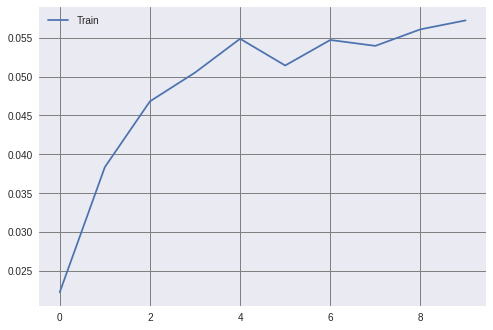

In [0]:
dense_net = StupidDenseNet()
print(dense_net)
train_network(dense_net, torch.device(DEVICE), a_epochs=10)

StupidDenseNet(
  (classifier): Sequential(
    (lin1): Linear(in_features=3072, out_features=500, bias=True)
    (sig1): Sigmoid()
    (lin2): Linear(in_features=500, out_features=300, bias=True)
    (sig2): Sigmoid()
    (lin3): Linear(in_features=300, out_features=100, bias=True)
    (sig3): Sigmoid()
  )
)
Epoch  0 0.0212
Epoch time :  22.00915241241455
Epoch  1 0.0413
Epoch time :  21.644447565078735
Epoch  2 0.0473
Epoch time :  22.142527103424072
Epoch  3 0.0546
Epoch time :  22.137252807617188
Epoch  4 0.055
Epoch time :  22.048515558242798
Epoch  5 0.0556
Epoch time :  22.18386745452881
Epoch  6 0.0538
Epoch time :  21.680161237716675
Epoch  7 0.0555
Epoch time :  22.079867839813232
Epoch  8 0.0594
Epoch time :  22.17451310157776
Epoch  9 0.058
Epoch time :  22.166728258132935
Finished Training
Total time :  220.26726579666138


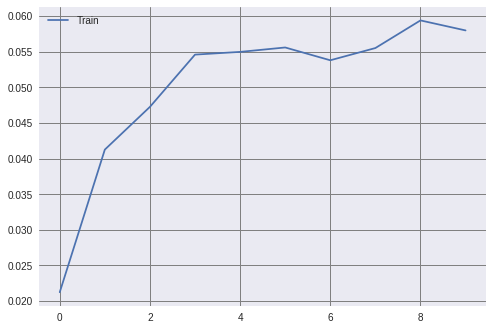

In [0]:
dense_net = StupidDenseNet()
print(dense_net)
train_network(dense_net, torch.device("cpu"), a_epochs=10)

StupidDenseNet(
  (classifier): Sequential(
    (lin1): Linear(in_features=3072, out_features=500, bias=True)
    (sig1): Sigmoid()
    (lin2): Linear(in_features=500, out_features=300, bias=True)
    (sig2): Sigmoid()
    (lin3): Linear(in_features=300, out_features=100, bias=True)
    (sig3): Sigmoid()
  )
)
Epoch  0 0.023
Epoch time :  12.706971645355225
Epoch  1 0.0405
Epoch time :  12.933391094207764
Epoch  2 0.0474
Epoch time :  12.834388017654419
Epoch  3 0.0529
Epoch time :  12.79670262336731
Epoch  4 0.0546
Epoch time :  12.722105264663696
Epoch  5 0.0547
Epoch time :  12.8203125
Epoch  6 0.057
Epoch time :  12.751272678375244
Epoch  7 0.0562
Epoch time :  12.552205324172974
Epoch  8 0.0561
Epoch time :  12.402451992034912
Epoch  9 0.0595
Epoch time :  12.46851658821106
Epoch  10 0.0633
Epoch time :  12.43105435371399
Epoch  11 0.0652
Epoch time :  12.768393754959106
Epoch  12 0.0688
Epoch time :  12.912647247314453
Epoch  13 0.0718
Epoch time :  12.766991138458252
Epoch  14 0

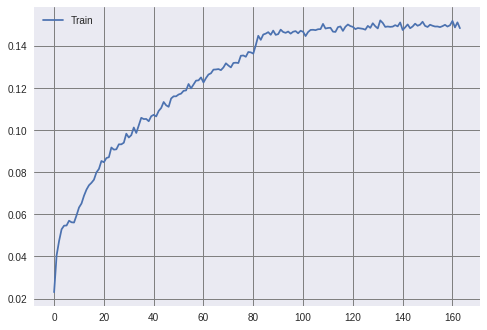

In [0]:
dense_net = StupidDenseNet()
print(dense_net)
train_network(dense_net, torch.device(DEVICE))

Epoch  0 0.0512
Epoch time :  17.152758359909058
Epoch  1 0.0836
Epoch time :  17.231831073760986
Epoch  2 0.095
Epoch time :  16.949000597000122
Epoch  3 0.1022
Epoch time :  16.98161005973816
Epoch  4 0.1078
Epoch time :  16.80350685119629
Epoch  5 0.1074
Epoch time :  16.99671506881714
Epoch  6 0.1157
Epoch time :  16.890616416931152
Epoch  7 0.113
Epoch time :  17.175105094909668
Epoch  8 0.1133
Epoch time :  17.25888156890869
Epoch  9 0.1108
Epoch time :  16.630109310150146
Finished Training
Total time :  170.0702304840088
CPU times: user 34.8 s, sys: 8.44 s, total: 43.2 s
Wall time: 2min 50s


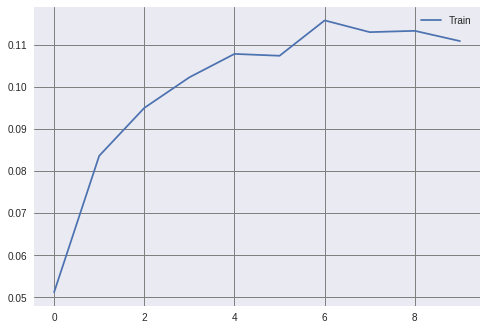

In [0]:
lenet = LeNet()
%time train_network(lenet, DEVICE, a_epochs=10)

Epoch  0 0.0513
Epoch time :  37.094388484954834
Epoch  1 0.0817
Epoch time :  37.073869466781616
Epoch  2 0.0982
Epoch time :  37.37975358963013
Epoch  3 0.1034
Epoch time :  36.59872126579285
Epoch  4 0.1044
Epoch time :  37.2047278881073
Epoch  5 0.1165
Epoch time :  36.726258516311646
Epoch  6 0.1204
Epoch time :  36.299192905426025
Epoch  7 0.1164
Epoch time :  34.50730037689209
Epoch  8 0.1191
Epoch time :  35.71913552284241
Epoch  9 0.1189
Epoch time :  35.87127876281738
Finished Training
Total time :  364.47560930252075
CPU times: user 3min 46s, sys: 17 s, total: 4min 3s
Wall time: 6min 4s


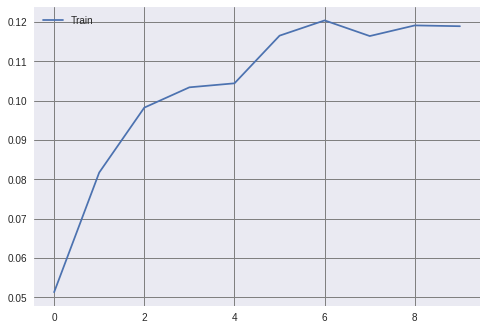

In [0]:
lenet = LeNet()
%time train_network(lenet, torch.device('cpu'), a_epochs=10)

Epoch  0 0.0479
Epoch time :  17.29044771194458
Epoch  1 0.0755
Epoch time :  17.32085680961609
Epoch  2 0.0876
Epoch time :  17.41103744506836
Epoch  3 0.0925
Epoch time :  17.384217977523804
Epoch  4 0.0966
Epoch time :  17.397150993347168
Epoch  5 0.105
Epoch time :  17.85965847969055
Epoch  6 0.1096
Epoch time :  17.432270526885986
Epoch  7 0.1159
Epoch time :  17.542974710464478
Epoch  8 0.1141
Epoch time :  17.385937213897705
Epoch  9 0.1195
Epoch time :  17.507293701171875
Epoch  10 0.1192
Epoch time :  17.27968668937683
Epoch  11 0.1228
Epoch time :  17.416542530059814
Epoch  12 0.1239
Epoch time :  17.34117317199707
Epoch  13 0.1215
Epoch time :  16.89591145515442
Epoch  14 0.1292
Epoch time :  16.4350688457489
Epoch  15 0.1253
Epoch time :  17.06035089492798
Epoch  16 0.1284
Epoch time :  17.357861280441284
Epoch  17 0.1294
Epoch time :  17.233599424362183
Epoch  18 0.13
Epoch time :  17.321565866470337
Epoch  19 0.13
Epoch time :  17.380154371261597
Epoch  20 0.131
Epoch tim

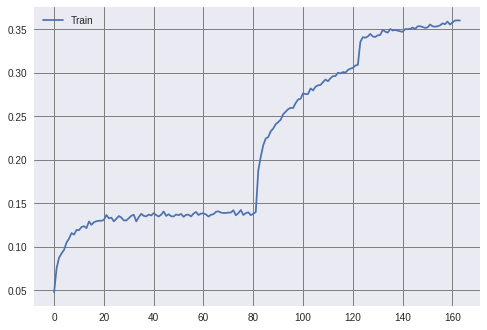

In [0]:
lenet = LeNet()
%time train_network(lenet, torch.device(DEVICE))

Epoch  0 0.0933
Epoch time :  128.4797339439392
Epoch  1 0.1979
Epoch time :  128.45537567138672
Epoch  2 0.2947
Epoch time :  128.4918987751007
Epoch  3 0.3749
Epoch time :  128.418527841568
Epoch  4 0.4423
Epoch time :  128.4009759426117
Epoch  5 0.4891
Epoch time :  128.3833305835724
Epoch  6 0.5323
Epoch time :  128.25076007843018
Epoch  7 0.5625
Epoch time :  128.4172785282135
Epoch  8 0.5858
Epoch time :  128.47650051116943
Epoch  9 0.6144
Epoch time :  128.32213234901428
Epoch  10 0.6327
Epoch time :  128.69048500061035
Epoch  11 0.6507
Epoch time :  128.5429344177246
Epoch  12 0.6684
Epoch time :  128.41847848892212
Epoch  13 0.6819
Epoch time :  128.55271291732788
Epoch  14 0.6965
Epoch time :  128.53040885925293
Epoch  15 0.7062
Epoch time :  128.7189507484436
Epoch  16 0.7176
Epoch time :  128.44962882995605
Epoch  17 0.7294
Epoch time :  128.3271062374115
Epoch  18 0.7395
Epoch time :  128.21746397018433
Epoch  19 0.7495
Epoch time :  128.40410900115967
Epoch  20 0.7599
Epo

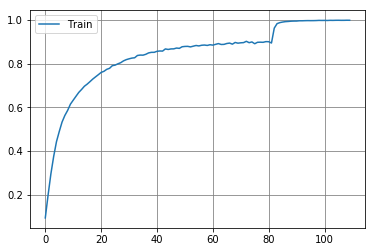

In [46]:
resnet = CifarResNet()
train_network(resnet, torch.device(DEVICE), a_epochs=110)

# Важно переключить сеть в режим eval - иначе dropout будет работать некорректно

In [0]:
def make_solution(a_net, a_device):
    res = []
    net = a_net.eval()
    for item in dataloader_test_norm:
        inputs = item.to(a_device)
        outputs = net(inputs) 

        res += prediction2classes(outputs)
    return res

In [0]:
# my_solution = make_solution(dense_net, DEVICE)
my_solution = make_solution(resnet, DEVICE)

In [0]:
file_name = DATA_PATH + 'my_solution_lenet.csv'

with open(file_name, 'w') as fout:
    print('Id', 'Prediction', sep=',', file=fout)
    for i, prediction in enumerate(my_solution):
        print(i, prediction, sep=',', file=fout)
        
# from google.colab import files
# files.download(file_name)